# Practical Assesment Task #1: Colorizing Images with Generative Adversarial Networks
Técnicas Generativas y Aprendizaje por Refuerzo - Curso 2023/2024



## Import Dependencies and Set General Parameters

In [1]:
# Import libraries
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.layers import (
    Activation, AveragePooling2D, BatchNormalization, Conv2D, Dense, 
    Dropout, Flatten, LeakyReLU, UpSampling2D)
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from time import time
from skimage.color import rgb2lab, lab2rgb
from pathlib import Path
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential

# Enable memory growth for GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Constants
IMAGE_SIZE = 32
EPOCHS = 200 # Increase or decrease as appropriate
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 100

WORKDIR = "content/drive/My Drive/Colab Notebooks/Workspace/"

# Create directories
Path(WORKDIR).mkdir(parents=True, exist_ok=True)
Path(f"{WORKDIR}/results").mkdir(parents=True, exist_ok=True)

2024-02-22 17:14:55.977962: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-22 17:14:56.002810: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 17:14:56.002837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 17:14:56.003500: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 17:14:56.007969: I tensorflow/core/platform/cpu_feature_guar

## Define Dataset Loader

In [2]:
def generate_dataset(images, debug=False):
    """
    This function converts a list of RGB images to the LAB color space, and separates the L channel from the A and B channels.
    The images are normalized and reshaped to the appropriate dimensions for the model.

    Parameters:
    images (list): A list of RGB images
    debug (bool): If True, the function will display the original and converted images

    Returns:
    X (np.array): A numpy array of L channels of the images
    Y (np.array): A numpy array of A and B channels of the images
    """
    X = []
    Y = []

    for i in images:
        lab_image_array = rgb2lab(i / 255)  # Convert the image from RGB to LAB color space
        x = lab_image_array[:, :, 0]  # Get the L channel
        y = lab_image_array[:, :, 1:]  # Get the A and B channels
        y /= 128  # normalize

        if debug:  # If debug is True, display the original and converted images
            fig = plt.figure()
            fig.add_subplot(1, 2, 1)
            plt.imshow(i / 255)

            fig.add_subplot(1, 2, 2)
            plt.imshow(lab2rgb(np.dstack((x, y * 128))))
            plt.show()

        X.append(x.reshape(IMAGE_SIZE, IMAGE_SIZE, 1))  # Reshape the L channel and append to the list
        Y.append(y)  # Append the A and B channels to the list

    X = np.array(X, dtype=np.float32)  # Convert the list to a numpy array
    Y = np.array(Y, dtype=np.float32)  # Convert the list to a numpy array

    return X, Y


def load_data(force=False):
    """
    This function loads the CIFAR-10 dataset, processes it, and saves/loads the processed data to/from the disk.

    Parameters:
    force (bool): If True, the function will reprocess the data even if it already exists on the disk

    Returns:
    X_train, Y_train, X_test, Y_test (np.array): Numpy arrays of the training and testing data
    """
    is_saved_arrays_exist = os.path.isfile(os.path.join(WORKDIR, 'X_train.npy'))  # Check if the processed data already exists on the disk

    if not is_saved_arrays_exist or force:  # If the processed data does not exist or if force is True, process the data
        (train_images, _), (test_images, _) = cifar10.load_data()  # Load the CIFAR-10 dataset
        X_train, Y_train = generate_dataset(train_images)  # Process the training images
        X_test, Y_test = generate_dataset(test_images)  # Process the testing images
        print('Saving processed data to Drive')
        np.save(os.path.join(WORKDIR, 'X_train.npy'), X_train)  # Save the processed training data to the disk
        np.save(os.path.join(WORKDIR, 'Y_train.npy'), Y_train)  # Save the processed training data to the disk
        np.save(os.path.join(WORKDIR, 'X_test.npy'), X_test)  # Save the processed testing data to the disk
        np.save(os.path.join(WORKDIR, 'Y_test.npy'), Y_test)  # Save the processed testing data to the disk
    else:  # If the processed data exists and force is False, load the data from the disk
        print('Loading processed data from Drive')
        X_train = np.load(os.path.join(WORKDIR, 'X_train.npy'))  # Load the processed training data from the disk
        Y_train = np.load(os.path.join(WORKDIR, 'Y_train.npy'))  # Load the processed training data from the disk
        X_test = np.load(os.path.join(WORKDIR, 'X_test.npy'))  # Load the processed testing data from the disk
        Y_test = np.load(os.path.join(WORKDIR, 'Y_test.npy'))  # Load the processed testing data from the disk

    return X_train, Y_train, X_test, Y_test

## Load Dataset

In [3]:
# Load the processed training and testing data
X_train, Y_train, X_test, Y_test = load_data()

# Create TensorFlow datasets from the training and testing data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

# Shuffle the training dataset and batch both datasets
# SHUFFLE_BUFFER_SIZE determines the randomness of the shuffling
# BATCH_SIZE determines the number of samples that will be propagated through the network at once
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Loading processed data from Drive


2024-02-22 17:14:58.398066: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-22 17:14:58.398354: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-22 17:14:58.398560: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-22 17:14:58.513912: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-22 17:14:58.514123: I external/local_xla/xla/stream_executor

## Define Generator Model

In [4]:
def build_generator_model():
    """
    This function builds the generator model for the GAN. The generator is responsible for generating new, fake images.
    It uses a series of Conv2D, BatchNormalization, and UpSampling2D layers.

    Returns:
    model (Sequential): The generator model
    """
    model = Sequential()  # Initialize the model

    # Suggested architecture:
    # Downsampling
    # Add a series of Conv2D layers followed by BatchNormalization layers
    # Conv2D layers are used for the convolution operation that extracts features from the input images
    # Conv2D layers with stride=1 preserve the dimensions of the image
    # Conv2D layers with stride=2 downsample the image (i.e., reduce the dimensions of the image by half)
    # BatchNormalization layers are used to normalize the activations of the previous layer at each batch
    # ReLU activation function is used to add non-linearity to the output of the previous layer
    # Padding is set to 'same' to preserve the dimensions of the image
    # Repeat this series of layers N times

    # Upsampling
    # UpSampling2D layer is used to increase the dimension of the image
    # Add as many UpSampling2D layers as Conv2D layers with stride=2 to upsample the image to its original dimensions
    # Add a series of Conv2D layers followed by BatchNormalization layers
    # BatchNormalization layers are used to normalize the activations of the previous layer at each batch
    # ReLU activation function is used to add non-linearity to the output of the previous layer

    # Output layer
    # Add a Conv2D layer with 2 filters to output the A and B LAB channels of the image
    # Activation layer is used to apply the tanh activation function to the output
    # tanh activation function is used because the pixels of the output images range from -1 to 1

    # Downsampling
    # Initial layer to expand the input dimension
    model.add(
        Conv2D(
            128, kernel_size=(3, 3), strides=1, padding="same", input_shape=(32, 32, 1)
        )
    )
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # Further downsampling - Conv2D layers with stride=2
    model.add(Conv2D(256, kernel_size=(3, 3), strides=2, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(512, kernel_size=(3, 3), strides=2, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # Upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=(3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=(3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # Output layer
    model.add(Conv2D(2, kernel_size=(3, 3), padding="same"))
    model.add(Activation("tanh"))

    return model

## Define Discriminator Model

In [5]:
def build_discriminator_model():
    """
    This function builds the discriminator model for the GAN. The discriminator is responsible for distinguishing real images from fake ones.
    It is recommended to use a series of Conv2D, Dropout, AveragePooling2D, Flatten, Dense, LeakyReLU, BatchNormalization, and Activation layers to create the model.

    Returns:
    model (Sequential): The discriminator model
    """

    model = Sequential()  # Initialize the model

    # Suggested architecture:
    # Convolution blocks
    # Add a series of Conv2D layers followed by Dropout
    # Conv2D layers are used for the convolution operation that extracts features from the input images
    # Dropout layers are used to prevent overfitting by randomly setting a fraction rate of input units to 0 at each update during training time
    # Repeat this series of layers N times

    # Pooling and dense layers
    # AveragePooling2D layer is used to downscale the image spatially
    # Flatten layer is used to convert the 2D matrix of features into a vector that can be fed into a fully connected neural network classifier
    # Dense layers are the regular deeply connected neural network layers
    # LeakyReLU is a type of activation function that allows a small gradient when the unit is not active
    # BatchNormalization layers are used to normalize the activations of the previous layer at each batch
    # Dropout layers are used to prevent overfitting by randomly setting a fraction rate of input units to 0 at each update during training time

    # Output layer
    # Add a Dense layer with 1 unit to output the probability of the input image being real or synthetic
    # Activation layer is used to apply the sigmoid activation function to the output
    # sigmoid activation function is used because the output is a probability between 0 and 1

    # Convolution blocks
    model.add(
        Conv2D(
            64, kernel_size=(3, 3), strides=2, padding="same", input_shape=(32, 32, 2)
        )
    )
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, kernel_size=(3, 3), strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, kernel_size=(3, 3), strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    # Pooling and dense layers
    model.add(AveragePooling2D())
    model.add(Flatten())
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    # Output layer
    model.add(Dense(1))
    model.add(Activation("sigmoid"))

    return model

## Define Generator and Discriminator Loss Functions

In [6]:
# Define the weight of the GAN loss
gan_loss_weight = 1

# Define the regularization parameter for the generator's L2 loss
l2_lambda = 150 

# Define the loss function for the discriminator
# Binary Cross Entropy is used as the loss function since we are dealing with a binary classification problem (real vs fake images)
cross_entropy = tf.keras.losses.BinaryCrossentropy() 

def discriminator_loss(disc_real_output, disc_generated_output):
    """
    This function calculates the total loss for the discriminator.

    Parameters:
    disc_real_output (Tensor): The discriminator's prediction on the real images
    disc_generated_output (Tensor): The discriminator's prediction on the generated (fake) images

    Returns:
    total_disc_loss (Tensor): The total loss for the discriminator
    """

    total_disc_loss = 0  # Initialize the total loss for the discriminator

    # Calculate the cross entropy loss for the real images
    real_loss = cross_entropy(tf.ones_like(disc_real_output), disc_real_output)

    # Calculate the cross entropy loss for the generated (synthetic) images
    generated_loss = cross_entropy(
        tf.zeros_like(disc_generated_output), disc_generated_output
    )

    # Calculate the total loss for the discriminator by adding the losses for the real and generated images
    total_disc_loss = real_loss + generated_loss

    # Return the total loss for the discriminator
    return total_disc_loss


def generator_loss(disc_generated_output, gen_output, target):
    """
    This function calculates the total loss for the generator.

    Parameters:
    disc_generated_output (Tensor): The discriminator's prediction on the generated (fake) images
    gen_output (Tensor): The generated (fake) images
    target (Tensor): The real images

    Returns:
    total_gen_loss (Tensor): The total loss for the generator
    gan_loss (Tensor): The GAN loss for the generator
    l2_loss (Tensor): The L2 loss for the generator
    """

    total_gen_loss = 0  # Initialize the total loss for the generator
    gan_loss = 0  # Initialize the GAN loss for the generator
    l2_loss = 0  # Initialize the L2 loss for the generator

    # Calculate the GAN loss for the generator (i.e., the loss for fooling the discriminator)
    gan_loss = cross_entropy(tf.ones_like(disc_generated_output), disc_generated_output)

    # Calculate the L2 loss for the generator by comparing the generated images to the real images
    l2_loss = tf.reduce_mean(tf.square(target - gen_output))

    # Calculate the total loss for the generator by adding the GAN loss (multiplied by its corresponding weight) and the L2 loss (multiplied by the regularization parameter)
    total_gen_loss = gan_loss + l2_lambda * l2_loss

    # Return the total loss, GAN loss, and L2 loss for the generator
    return total_gen_loss, gan_loss, l2_loss

## Build Generator and Discriminator Models

In [7]:
# Instantiate the generator and discriminator models
generator = build_generator_model()
discriminator = build_discriminator_model()

# Print out the model summaries
generator.summary()
discriminator.summary()

# Define the optimizers for the generator and discriminator
# Adam optimizer is used with a learning rate of 2e-4 and beta_1 (the exponential decay rate for the first moment estimates) of 0.5
# It is recommended to experiment with different values for the learning rate. Beta_1 value of 0.5 is recommended for GANs
# It is possible that the optimal learning rate for the generator and discriminator is different from each other
gen_learning_rate = 2e-4
gene_beta_1 = 0.5

disc_learning_rate = 2e-4
disc_beta_1 = 0.5

generator_optimizer = tf.keras.optimizers.Adam(gen_learning_rate, beta_1=gene_beta_1)
discriminator_optimizer = tf.keras.optimizers.Adam(disc_learning_rate, beta_1=disc_beta_1)

# Define the directory for storing the training checkpoints
checkpoint_dir = os.path.join(WORKDIR, 'training-checkpoints')
# Define the prefix for the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# Create a checkpoint object which will be used to save and load the models and optimizers
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
# Create a manager for the checkpoint object, which will be responsible for saving and loading the checkpoints
# max_to_keep parameter is set to 3, meaning that only the 3 most recent checkpoints will be kept
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       1280      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 128)       512       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 256)       1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0

In [8]:
# Define the directory and file for storing the TensorBoard summary logs
summary_log_file = os.path.join(
    WORKDIR, 'tf-summary', datetime.now().strftime("%Y%m%d-%H%M%S"))
# Create a summary writer for writing the summary logs
summary_writer = tf.summary.create_file_writer(summary_log_file)

@tf.function
def train_step(input_image, target, epoch):
    """
    This function performs one training step for the generator and discriminator.

    Parameters:
    input_image (Tensor): The input image
    target (Tensor): The target image
    epoch (int): The current epoch number

    Returns:
    gen_total_loss (Tensor): The total loss for the generator
    disc_loss (Tensor): The loss for the discriminator
    """

    # Open a GradientTape context for automatic differentiation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_total_loss = 0  # Initialize the total loss for the generator
        gen_gan_loss = 0  # Initialize the GAN loss for the generator
        gen_l2_loss = 0  # Initialize the L2 loss for the generator
        disc_loss = 0  # Initialize the loss for the discriminator

        # Generate an image using the generator
        # (remember to set training=True, since during training time BatchNormalization layers are applied using the batch mean and variance)
        gen_output = generator(input_image, training=True)

        # Get the discriminator's predictions on the real and generated images
        # (remember to set training=True, since during training time BatchNormalization layers are applied using the batch mean and variance)
        disc_real_output = discriminator(target, training=True)
        disc_generated_output = discriminator(gen_output, training=True)

        # Calculate the losses for the generator and discriminator
        gen_total_loss, gen_gan_loss, gen_l2_loss = generator_loss(
            disc_generated_output, gen_output, target
        )
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Calculate the gradients of the generator's and discriminator's losses with respect to the trainable variables of each model
    # Use the gradient() method of the GradientTape object of each model to calculate the gradients of the losses with respect to the trainable variables of the corresponding model
    # Model's trainable variables can be accessed using the trainable_variables attribute
    generator_gradients = gen_tape.gradient(
        gen_total_loss, generator.trainable_variables
    )
    discriminator_gradients = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    # Apply the gradients to the model's trainable variables
    # Use the apply_gradients() method of the optimizer object to apply the gradients
    # The apply_gradients() method takes a list of (gradient, variable) pairs
    # zip() function can be used to iterate over two lists simultaneously (i.e., the gradients and the model's trainable variables)
    generator_optimizer.apply_gradients(
        zip(generator_gradients, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(discriminator_gradients, discriminator.trainable_variables)
    )

    # Write the losses to the summary logs
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l2_loss', gen_l2_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

    return gen_total_loss, disc_loss

In [9]:
# The checkpoint manager will load the latest checkpoint if it exists
# This will be used to resume training if the training process was interrupted
# If no checkpoint exists, the models will be initialized from scratch

# Restore the latest checkpoint using the checkpoint manager
checkpoint.restore(manager.latest_checkpoint)

# If a checkpoint was found and restored, print a message indicating the checkpoint file
if manager.latest_checkpoint:
    print('Restored from {}'.format(manager.latest_checkpoint))
    
# If no checkpoint was found, print a message indicating that the models are being initialized from scratch
else:
    print('Initializing from scratch')

Initializing from scratch


In [10]:
# Loop over the epochs
for e in tqdm(range(EPOCHS)):
    # Record the start time of the epoch
    start_time = time()

    gen_loss_total = 0  # Initialize the total loss for the generator
    disc_loss_total = 0  # Initialize the total loss for the discriminator

    # Loop over the training dataset
    for input_image, target in train_dataset:
        # Perform one training step and get the generator and discriminator losses
        gen_loss, disc_loss = train_step(input_image, target, e)

        # Add the losses to the total losses
        gen_loss_total += gen_loss
        disc_loss_total += disc_loss

    # Calculate the time taken for the epoch
    time_taken = time() - start_time

    # If the epoch number is a multiple of 10, save a checkpoint
    if (e + 1) % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    # Print the epoch number, average generator loss, average discriminator loss, and time taken
    # print('Epoch {}: gen loss: {}, disc loss: {}, time: {:.2f}s'.format(
    #     e + 1, gen_loss_total / BATCH_SIZE, disc_loss_total / BATCH_SIZE, time_taken))
    print(f'Epoch {e + 1}: gen loss: {gen_loss_total / BATCH_SIZE}, disc loss: {disc_loss_total / BATCH_SIZE}, time: {time_taken:.2f}s')

  0%|          | 0/200 [00:00<?, ?it/s]2024-02-22 17:15:00.807235: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-22 17:15:01.017313: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-02-22 17:15:01.100124: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-22 17:15:01.472249: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-22 17:15:04.231372: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe027ff8570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-22 17:15:04.231408: I external/local_xla/xla/service/service.cc:176]   StreamE

Epoch 1: gen loss: 11.316513061523438, disc loss: 4.241524696350098, time: 42.43s


2024-02-22 17:16:08.898390: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
  1%|          | 2/200 [01:09<1:50:55, 33.62s/it]

Epoch 2: gen loss: 7.31569242477417, disc loss: 4.235010623931885, time: 27.44s


  2%|▏         | 3/200 [01:37<1:41:08, 30.81s/it]

Epoch 3: gen loss: 7.137261390686035, disc loss: 4.234858989715576, time: 27.46s


  2%|▏         | 4/200 [02:04<1:36:25, 29.52s/it]

Epoch 4: gen loss: 7.021231651306152, disc loss: 4.234796524047852, time: 27.54s


2024-02-22 17:17:31.246658: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
  2%|▎         | 5/200 [02:32<1:33:23, 28.73s/it]

Epoch 5: gen loss: 6.987062454223633, disc loss: 4.234775066375732, time: 27.34s


  3%|▎         | 6/200 [02:59<1:31:39, 28.35s/it]

Epoch 6: gen loss: 6.934196472167969, disc loss: 4.234763145446777, time: 27.60s


  4%|▎         | 7/200 [03:27<1:30:13, 28.05s/it]

Epoch 7: gen loss: 6.926236152648926, disc loss: 4.234747409820557, time: 27.43s


2024-02-22 17:18:53.755685: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
  4%|▍         | 8/200 [03:54<1:29:10, 27.87s/it]

Epoch 8: gen loss: 6.886394023895264, disc loss: 4.234726905822754, time: 27.47s


  4%|▍         | 9/200 [04:22<1:28:15, 27.73s/it]

Epoch 9: gen loss: 6.874485492706299, disc loss: 4.234719753265381, time: 27.42s


  5%|▌         | 10/200 [04:49<1:27:44, 27.71s/it]

Epoch 10: gen loss: 6.845643520355225, disc loss: 4.2347092628479, time: 27.45s


2024-02-22 17:20:16.415581: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
  6%|▌         | 11/200 [05:17<1:27:08, 27.67s/it]

Epoch 11: gen loss: 6.840184211730957, disc loss: 4.234707832336426, time: 27.56s


  6%|▌         | 12/200 [05:45<1:26:46, 27.70s/it]

Epoch 12: gen loss: 6.82342004776001, disc loss: 4.234704494476318, time: 27.76s


  6%|▋         | 13/200 [06:12<1:26:06, 27.63s/it]

Epoch 13: gen loss: 6.793370246887207, disc loss: 4.2347025871276855, time: 27.47s


2024-02-22 17:21:39.081009: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
  7%|▋         | 14/200 [06:40<1:25:28, 27.57s/it]

Epoch 14: gen loss: 6.791789531707764, disc loss: 4.23469877243042, time: 27.43s


  8%|▊         | 15/200 [07:07<1:24:55, 27.54s/it]

Epoch 15: gen loss: 6.800540924072266, disc loss: 4.234695911407471, time: 27.48s


  8%|▊         | 16/200 [07:35<1:24:24, 27.52s/it]

Epoch 16: gen loss: 6.76862096786499, disc loss: 4.234694480895996, time: 27.48s


2024-02-22 17:23:01.625771: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
  8%|▊         | 17/200 [08:02<1:24:00, 27.54s/it]

Epoch 17: gen loss: 6.758779048919678, disc loss: 4.234694004058838, time: 27.58s


  9%|▉         | 18/200 [08:30<1:23:29, 27.52s/it]

Epoch 18: gen loss: 6.750308513641357, disc loss: 4.23469352722168, time: 27.48s


 10%|▉         | 19/200 [08:57<1:22:59, 27.51s/it]

Epoch 19: gen loss: 6.731963157653809, disc loss: 4.234692573547363, time: 27.48s


2024-02-22 17:24:24.446126: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 10%|█         | 20/200 [09:25<1:22:58, 27.66s/it]

Epoch 20: gen loss: 6.7172532081604, disc loss: 4.234692573547363, time: 27.85s


 10%|█         | 21/200 [09:53<1:22:29, 27.65s/it]

Epoch 21: gen loss: 6.735545635223389, disc loss: 4.234692096710205, time: 27.63s


 11%|█         | 22/200 [10:20<1:21:51, 27.59s/it]

Epoch 22: gen loss: 6.710054397583008, disc loss: 4.234692096710205, time: 27.45s


2024-02-22 17:25:47.196344: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 12%|█▏        | 23/200 [10:48<1:21:19, 27.57s/it]

Epoch 23: gen loss: 6.684234142303467, disc loss: 4.234691619873047, time: 27.51s


 12%|█▏        | 24/200 [11:14<1:19:34, 27.13s/it]

Epoch 24: gen loss: 6.692934036254883, disc loss: 4.234691619873047, time: 26.10s


 12%|█▎        | 25/200 [11:40<1:18:23, 26.88s/it]

Epoch 25: gen loss: 6.677370548248291, disc loss: 4.234691619873047, time: 26.29s


2024-02-22 17:27:05.978447: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 13%|█▎        | 26/200 [12:06<1:17:30, 26.73s/it]

Epoch 26: gen loss: 6.708174228668213, disc loss: 4.234691619873047, time: 26.38s


 14%|█▎        | 27/200 [12:33<1:16:43, 26.61s/it]

Epoch 27: gen loss: 6.6524739265441895, disc loss: 4.234691143035889, time: 26.33s


 14%|█▍        | 28/200 [12:59<1:15:58, 26.50s/it]

Epoch 28: gen loss: 6.667929172515869, disc loss: 4.234689712524414, time: 26.24s


2024-02-22 17:28:24.832667: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 14%|█▍        | 29/200 [13:25<1:15:21, 26.44s/it]

Epoch 29: gen loss: 6.678544998168945, disc loss: 4.234689235687256, time: 26.30s


 15%|█▌        | 30/200 [13:52<1:15:09, 26.53s/it]

Epoch 30: gen loss: 6.615432262420654, disc loss: 4.234689235687256, time: 26.51s


 16%|█▌        | 31/200 [14:18<1:14:29, 26.45s/it]

Epoch 31: gen loss: 6.619143486022949, disc loss: 4.234688758850098, time: 26.27s


2024-02-22 17:29:43.955471: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 16%|█▌        | 32/200 [14:44<1:13:46, 26.35s/it]

Epoch 32: gen loss: 6.619802951812744, disc loss: 4.234688758850098, time: 26.10s


 16%|█▋        | 33/200 [15:11<1:13:26, 26.39s/it]

Epoch 33: gen loss: 6.592316150665283, disc loss: 4.234688758850098, time: 26.49s


 17%|█▋        | 34/200 [15:39<1:14:20, 26.87s/it]

Epoch 34: gen loss: 6.596381664276123, disc loss: 4.234688758850098, time: 27.99s


2024-02-22 17:31:06.305621: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 18%|█▊        | 35/200 [16:07<1:14:43, 27.17s/it]

Epoch 35: gen loss: 6.5639328956604, disc loss: 4.234688758850098, time: 27.87s


 18%|█▊        | 36/200 [16:35<1:14:47, 27.36s/it]

Epoch 36: gen loss: 6.570516109466553, disc loss: 4.234688758850098, time: 27.81s


 18%|█▊        | 37/200 [17:02<1:14:38, 27.48s/it]

Epoch 37: gen loss: 6.557373046875, disc loss: 4.234688758850098, time: 27.75s


2024-02-22 17:32:29.734659: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 19%|█▉        | 38/200 [17:30<1:14:30, 27.60s/it]

Epoch 38: gen loss: 6.530941009521484, disc loss: 4.234688758850098, time: 27.87s


 20%|█▉        | 39/200 [17:58<1:14:06, 27.62s/it]

Epoch 39: gen loss: 6.54834508895874, disc loss: 4.234688758850098, time: 27.67s


 20%|██        | 40/200 [18:26<1:13:40, 27.63s/it]

Epoch 40: gen loss: 6.501987934112549, disc loss: 4.234688758850098, time: 27.51s


2024-02-22 17:33:52.657515: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 20%|██        | 41/200 [18:53<1:13:11, 27.62s/it]

Epoch 41: gen loss: 6.480012893676758, disc loss: 4.234688758850098, time: 27.59s


 21%|██        | 42/200 [19:21<1:12:41, 27.60s/it]

Epoch 42: gen loss: 6.49263334274292, disc loss: 4.234688758850098, time: 27.57s


 22%|██▏       | 43/200 [19:49<1:12:35, 27.74s/it]

Epoch 43: gen loss: 6.465922832489014, disc loss: 4.234688758850098, time: 28.06s


2024-02-22 17:35:15.915705: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 22%|██▏       | 44/200 [20:16<1:12:02, 27.71s/it]

Epoch 44: gen loss: 6.452073574066162, disc loss: 4.234688758850098, time: 27.63s


 22%|██▎       | 45/200 [20:44<1:11:20, 27.62s/it]

Epoch 45: gen loss: 6.4356489181518555, disc loss: 4.234688758850098, time: 27.41s


 23%|██▎       | 46/200 [21:11<1:10:47, 27.58s/it]

Epoch 46: gen loss: 6.435565948486328, disc loss: 4.234688758850098, time: 27.51s


2024-02-22 17:36:38.303101: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 24%|██▎       | 47/200 [21:39<1:10:15, 27.55s/it]

Epoch 47: gen loss: 6.398014068603516, disc loss: 4.234688758850098, time: 27.47s


 24%|██▍       | 48/200 [22:06<1:09:48, 27.56s/it]

Epoch 48: gen loss: 6.399914264678955, disc loss: 4.234688758850098, time: 27.57s


 24%|██▍       | 49/200 [22:34<1:09:14, 27.52s/it]

Epoch 49: gen loss: 6.3933515548706055, disc loss: 4.234688758850098, time: 27.42s


2024-02-22 17:38:01.008817: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 25%|██▌       | 50/200 [23:02<1:09:04, 27.63s/it]

Epoch 50: gen loss: 6.3633832931518555, disc loss: 4.234688758850098, time: 27.72s


 26%|██▌       | 51/200 [23:29<1:08:44, 27.68s/it]

Epoch 51: gen loss: 6.363897800445557, disc loss: 4.234688758850098, time: 27.80s


 26%|██▌       | 52/200 [24:10<1:18:06, 31.66s/it]

Epoch 52: gen loss: 6.34153413772583, disc loss: 4.234688758850098, time: 40.94s


2024-02-22 17:39:10.642960: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 26%|██▋       | 53/200 [24:38<1:14:43, 30.50s/it]

Epoch 53: gen loss: 6.317421913146973, disc loss: 4.234688758850098, time: 27.77s


 27%|██▋       | 54/200 [25:06<1:12:05, 29.62s/it]

Epoch 54: gen loss: 6.311490535736084, disc loss: 4.234688758850098, time: 27.59s


2024-02-22 17:40:32.915087: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 28%|██▊       | 55/200 [25:33<1:10:07, 29.02s/it]

Epoch 55: gen loss: 6.3106913566589355, disc loss: 4.234688758850098, time: 27.60s


 28%|██▊       | 56/200 [26:01<1:08:35, 28.58s/it]

Epoch 56: gen loss: 6.301506519317627, disc loss: 4.234688758850098, time: 27.56s


 28%|██▊       | 57/200 [26:28<1:07:22, 28.27s/it]

Epoch 57: gen loss: 6.289698600769043, disc loss: 4.234688758850098, time: 27.54s


2024-02-22 17:41:56.328202: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 29%|██▉       | 58/200 [26:57<1:06:56, 28.28s/it]

Epoch 58: gen loss: 6.273804664611816, disc loss: 4.234688758850098, time: 28.32s


 30%|██▉       | 59/200 [27:25<1:06:15, 28.19s/it]

Epoch 59: gen loss: 6.270257949829102, disc loss: 4.234688758850098, time: 27.98s


 30%|███       | 60/200 [27:53<1:05:49, 28.21s/it]

Epoch 60: gen loss: 6.2502851486206055, disc loss: 4.234688758850098, time: 28.04s


2024-02-22 17:43:20.650745: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 30%|███       | 61/200 [28:21<1:05:16, 28.18s/it]

Epoch 61: gen loss: 6.248438835144043, disc loss: 4.234688758850098, time: 28.10s


 31%|███       | 62/200 [28:49<1:04:40, 28.12s/it]

Epoch 62: gen loss: 6.23547887802124, disc loss: 4.234688758850098, time: 27.98s


 32%|███▏      | 63/200 [29:17<1:04:08, 28.09s/it]

Epoch 63: gen loss: 6.224621772766113, disc loss: 4.234688758850098, time: 28.04s


2024-02-22 17:44:44.605452: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 32%|███▏      | 64/200 [29:45<1:03:34, 28.05s/it]

Epoch 64: gen loss: 6.209238052368164, disc loss: 4.234688758850098, time: 27.93s


 32%|███▎      | 65/200 [30:13<1:02:56, 27.97s/it]

Epoch 65: gen loss: 6.199190616607666, disc loss: 4.234688758850098, time: 27.80s


 33%|███▎      | 66/200 [30:41<1:02:30, 27.99s/it]

Epoch 66: gen loss: 6.199862957000732, disc loss: 4.234688758850098, time: 28.02s


2024-02-22 17:46:08.465143: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 34%|███▎      | 67/200 [31:09<1:02:04, 28.00s/it]

Epoch 67: gen loss: 6.181652069091797, disc loss: 4.234688758850098, time: 28.04s


 34%|███▍      | 68/200 [31:37<1:01:37, 28.01s/it]

Epoch 68: gen loss: 6.16779088973999, disc loss: 4.234688758850098, time: 28.02s


 34%|███▍      | 69/200 [32:05<1:01:08, 28.00s/it]

Epoch 69: gen loss: 6.160438060760498, disc loss: 4.234688758850098, time: 27.99s


2024-02-22 17:47:32.126249: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 35%|███▌      | 70/200 [32:33<1:00:32, 27.94s/it]

Epoch 70: gen loss: 6.147913455963135, disc loss: 4.234688758850098, time: 27.64s


 36%|███▌      | 71/200 [33:00<59:54, 27.87s/it]  

Epoch 71: gen loss: 6.139312267303467, disc loss: 4.234688758850098, time: 27.69s


 36%|███▌      | 72/200 [33:28<59:22, 27.83s/it]

Epoch 72: gen loss: 6.119157791137695, disc loss: 4.234688758850098, time: 27.74s


2024-02-22 17:48:55.426701: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 36%|███▋      | 73/200 [33:56<58:49, 27.79s/it]

Epoch 73: gen loss: 6.109342098236084, disc loss: 4.234688758850098, time: 27.70s


 37%|███▋      | 74/200 [34:23<58:11, 27.71s/it]

Epoch 74: gen loss: 6.096174716949463, disc loss: 4.234688758850098, time: 27.51s


 38%|███▊      | 75/200 [34:51<57:34, 27.64s/it]

Epoch 75: gen loss: 6.095528602600098, disc loss: 4.234688758850098, time: 27.48s


2024-02-22 17:50:18.669681: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 38%|███▊      | 76/200 [35:19<57:29, 27.82s/it]

Epoch 76: gen loss: 6.076268196105957, disc loss: 4.234688758850098, time: 28.24s


 38%|███▊      | 77/200 [35:47<56:49, 27.72s/it]

Epoch 77: gen loss: 6.061553001403809, disc loss: 4.234688758850098, time: 27.49s


 39%|███▉      | 78/200 [36:14<56:12, 27.64s/it]

Epoch 78: gen loss: 6.050144195556641, disc loss: 4.234688758850098, time: 27.46s


2024-02-22 17:51:41.065021: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 40%|███▉      | 79/200 [36:42<55:37, 27.58s/it]

Epoch 79: gen loss: 6.037466049194336, disc loss: 4.234688758850098, time: 27.44s


 40%|████      | 80/200 [37:09<55:13, 27.61s/it]

Epoch 80: gen loss: 6.0190019607543945, disc loss: 4.234688758850098, time: 27.53s


 40%|████      | 81/200 [37:37<54:43, 27.59s/it]

Epoch 81: gen loss: 6.005181312561035, disc loss: 4.234688758850098, time: 27.54s


2024-02-22 17:53:03.781722: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 41%|████      | 82/200 [38:04<54:12, 27.56s/it]

Epoch 82: gen loss: 6.003623962402344, disc loss: 4.234688758850098, time: 27.49s


 42%|████▏     | 83/200 [38:32<53:39, 27.52s/it]

Epoch 83: gen loss: 5.988070964813232, disc loss: 4.234688758850098, time: 27.41s


 42%|████▏     | 84/200 [38:59<53:12, 27.52s/it]

Epoch 84: gen loss: 5.970728397369385, disc loss: 4.234688758850098, time: 27.54s


2024-02-22 17:54:26.302075: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 42%|████▎     | 85/200 [39:27<52:47, 27.54s/it]

Epoch 85: gen loss: 5.9591474533081055, disc loss: 4.234688758850098, time: 27.58s


 43%|████▎     | 86/200 [39:54<52:17, 27.52s/it]

Epoch 86: gen loss: 5.948730945587158, disc loss: 4.234688758850098, time: 27.47s


 44%|████▎     | 87/200 [40:22<51:46, 27.49s/it]

Epoch 87: gen loss: 5.936542510986328, disc loss: 4.234688758850098, time: 27.43s


2024-02-22 17:55:48.655215: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 44%|████▍     | 88/200 [40:49<51:18, 27.48s/it]

Epoch 88: gen loss: 5.9232940673828125, disc loss: 4.234688758850098, time: 27.46s


 44%|████▍     | 89/200 [41:17<50:52, 27.50s/it]

Epoch 89: gen loss: 5.909368991851807, disc loss: 4.234688758850098, time: 27.53s


 45%|████▌     | 90/200 [41:44<50:32, 27.57s/it]

Epoch 90: gen loss: 5.894619941711426, disc loss: 4.234688758850098, time: 27.57s


2024-02-22 17:57:11.411623: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 46%|████▌     | 91/200 [42:12<50:01, 27.54s/it]

Epoch 91: gen loss: 5.886674880981445, disc loss: 4.234688758850098, time: 27.47s


 46%|████▌     | 92/200 [42:39<49:33, 27.53s/it]

Epoch 92: gen loss: 5.87274694442749, disc loss: 4.234688758850098, time: 27.52s


 46%|████▋     | 93/200 [43:07<49:06, 27.54s/it]

Epoch 93: gen loss: 5.856495380401611, disc loss: 4.234688758850098, time: 27.54s


2024-02-22 17:58:33.962745: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 47%|████▋     | 94/200 [43:34<48:37, 27.53s/it]

Epoch 94: gen loss: 5.848232269287109, disc loss: 4.234688758850098, time: 27.50s


 48%|████▊     | 95/200 [44:02<48:13, 27.56s/it]

Epoch 95: gen loss: 5.826858043670654, disc loss: 4.234688758850098, time: 27.63s


 48%|████▊     | 96/200 [44:30<47:42, 27.52s/it]

Epoch 96: gen loss: 5.824797630310059, disc loss: 4.234688758850098, time: 27.43s


2024-02-22 17:59:56.672004: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 48%|████▊     | 97/200 [44:57<47:18, 27.56s/it]

Epoch 97: gen loss: 5.806100368499756, disc loss: 4.234688758850098, time: 27.63s


 49%|████▉     | 98/200 [45:25<47:14, 27.79s/it]

Epoch 98: gen loss: 5.7918596267700195, disc loss: 4.234688758850098, time: 28.33s


 50%|████▉     | 99/200 [45:53<46:38, 27.71s/it]

Epoch 99: gen loss: 5.7791876792907715, disc loss: 4.234688758850098, time: 27.52s


2024-02-22 18:01:19.972990: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 50%|█████     | 100/200 [46:21<46:07, 27.68s/it]

Epoch 100: gen loss: 5.764854431152344, disc loss: 4.234688758850098, time: 27.44s


 50%|█████     | 101/200 [46:48<45:33, 27.61s/it]

Epoch 101: gen loss: 5.7541937828063965, disc loss: 4.234688758850098, time: 27.46s


 51%|█████     | 102/200 [47:16<45:04, 27.59s/it]

Epoch 102: gen loss: 5.7373738288879395, disc loss: 4.234688758850098, time: 27.55s


2024-02-22 18:02:42.518668: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 52%|█████▏    | 103/200 [47:43<44:30, 27.53s/it]

Epoch 103: gen loss: 5.729287624359131, disc loss: 4.234688758850098, time: 27.38s


 52%|█████▏    | 104/200 [48:11<44:02, 27.53s/it]

Epoch 104: gen loss: 5.716063022613525, disc loss: 4.234688758850098, time: 27.53s


 52%|█████▎    | 105/200 [48:38<43:34, 27.52s/it]

Epoch 105: gen loss: 5.714280128479004, disc loss: 4.234688758850098, time: 27.50s


2024-02-22 18:04:05.086312: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 53%|█████▎    | 106/200 [49:06<43:07, 27.52s/it]

Epoch 106: gen loss: 5.712978363037109, disc loss: 4.234688758850098, time: 27.53s


 54%|█████▎    | 107/200 [49:33<42:39, 27.52s/it]

Epoch 107: gen loss: 5.670936107635498, disc loss: 4.234688758850098, time: 27.50s


 54%|█████▍    | 108/200 [50:01<42:11, 27.51s/it]

Epoch 108: gen loss: 5.6612772941589355, disc loss: 4.234688758850098, time: 27.50s


2024-02-22 18:05:27.545992: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 55%|█████▍    | 109/200 [50:28<41:42, 27.50s/it]

Epoch 109: gen loss: 5.650760650634766, disc loss: 4.234688758850098, time: 27.45s


 55%|█████▌    | 110/200 [50:56<41:19, 27.55s/it]

Epoch 110: gen loss: 5.638810157775879, disc loss: 4.234688758850098, time: 27.51s


 56%|█████▌    | 111/200 [51:23<40:52, 27.56s/it]

Epoch 111: gen loss: 5.6306610107421875, disc loss: 4.234688758850098, time: 27.57s


2024-02-22 18:06:50.374628: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 56%|█████▌    | 112/200 [51:51<40:25, 27.56s/it]

Epoch 112: gen loss: 5.612025260925293, disc loss: 4.234688758850098, time: 27.57s


 56%|█████▋    | 113/200 [52:19<40:12, 27.73s/it]

Epoch 113: gen loss: 5.6119303703308105, disc loss: 4.234688758850098, time: 28.12s


 57%|█████▋    | 114/200 [52:47<39:39, 27.67s/it]

Epoch 114: gen loss: 5.590731620788574, disc loss: 4.234688758850098, time: 27.54s


2024-02-22 18:08:13.578137: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 57%|█████▊    | 115/200 [53:14<39:08, 27.63s/it]

Epoch 115: gen loss: 5.578013896942139, disc loss: 4.234688758850098, time: 27.54s


 58%|█████▊    | 116/200 [53:42<38:39, 27.62s/it]

Epoch 116: gen loss: 5.571394920349121, disc loss: 4.234688758850098, time: 27.57s


 58%|█████▊    | 117/200 [54:09<38:08, 27.57s/it]

Epoch 117: gen loss: 5.5533833503723145, disc loss: 4.234688758850098, time: 27.47s


2024-02-22 18:09:36.215956: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 59%|█████▉    | 118/200 [54:37<37:41, 27.58s/it]

Epoch 118: gen loss: 5.541704177856445, disc loss: 4.234688758850098, time: 27.60s


 60%|█████▉    | 119/200 [55:04<37:11, 27.55s/it]

Epoch 119: gen loss: 5.5320258140563965, disc loss: 4.234688758850098, time: 27.49s


 60%|██████    | 120/200 [55:32<36:47, 27.60s/it]

Epoch 120: gen loss: 5.518276214599609, disc loss: 4.234688758850098, time: 27.54s


2024-02-22 18:10:58.992602: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 60%|██████    | 121/200 [55:59<36:19, 27.59s/it]

Epoch 121: gen loss: 5.508472919464111, disc loss: 4.234688758850098, time: 27.58s


 61%|██████    | 122/200 [56:27<35:48, 27.55s/it]

Epoch 122: gen loss: 5.497357368469238, disc loss: 4.234688758850098, time: 27.45s


 62%|██████▏   | 123/200 [56:54<35:20, 27.54s/it]

Epoch 123: gen loss: 5.4779438972473145, disc loss: 4.234688758850098, time: 27.51s


2024-02-22 18:12:21.587261: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 62%|██████▏   | 124/200 [57:22<34:55, 27.57s/it]

Epoch 124: gen loss: 5.480780601501465, disc loss: 4.234688758850098, time: 27.63s


 62%|██████▎   | 125/200 [57:51<34:49, 27.86s/it]

Epoch 125: gen loss: 5.466552734375, disc loss: 4.234688758850098, time: 28.53s


 63%|██████▎   | 126/200 [58:18<34:15, 27.77s/it]

Epoch 126: gen loss: 5.446547508239746, disc loss: 4.234688758850098, time: 27.58s


2024-02-22 18:13:45.213599: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 64%|██████▎   | 127/200 [58:46<33:41, 27.70s/it]

Epoch 127: gen loss: 5.440412998199463, disc loss: 4.234688758850098, time: 27.52s


 64%|██████▍   | 128/200 [59:13<33:11, 27.65s/it]

Epoch 128: gen loss: 5.432812213897705, disc loss: 4.234688758850098, time: 27.55s


 64%|██████▍   | 129/200 [59:41<32:41, 27.63s/it]

Epoch 129: gen loss: 5.4190778732299805, disc loss: 4.234688758850098, time: 27.58s


2024-02-22 18:15:07.837461: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 65%|██████▌   | 130/200 [1:00:09<32:15, 27.65s/it]

Epoch 130: gen loss: 5.4068379402160645, disc loss: 4.234688758850098, time: 27.49s


 66%|██████▌   | 131/200 [1:00:35<31:27, 27.36s/it]

Epoch 131: gen loss: 5.394209384918213, disc loss: 4.234688758850098, time: 26.69s


 66%|██████▌   | 132/200 [1:01:02<30:43, 27.11s/it]

Epoch 132: gen loss: 5.384459018707275, disc loss: 4.234688758850098, time: 26.54s


2024-02-22 18:16:27.802155: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 66%|██████▋   | 133/200 [1:01:28<30:05, 26.94s/it]

Epoch 133: gen loss: 5.373471736907959, disc loss: 4.234688758850098, time: 26.54s


 67%|██████▋   | 134/200 [1:01:55<29:30, 26.83s/it]

Epoch 134: gen loss: 5.3603196144104, disc loss: 4.234688758850098, time: 26.55s


 68%|██████▊   | 135/200 [1:02:21<28:58, 26.75s/it]

Epoch 135: gen loss: 5.351921081542969, disc loss: 4.234688758850098, time: 26.56s


2024-02-22 18:17:47.403101: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 68%|██████▊   | 136/200 [1:02:48<28:26, 26.67s/it]

Epoch 136: gen loss: 5.339188098907471, disc loss: 4.234688758850098, time: 26.48s


 68%|██████▊   | 137/200 [1:03:15<27:59, 26.65s/it]

Epoch 137: gen loss: 5.326076030731201, disc loss: 4.234688758850098, time: 26.63s


 69%|██████▉   | 138/200 [1:03:41<27:30, 26.63s/it]

Epoch 138: gen loss: 5.319716453552246, disc loss: 4.234688758850098, time: 26.56s


2024-02-22 18:19:07.011869: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 70%|██████▉   | 139/200 [1:04:07<27:00, 26.57s/it]

Epoch 139: gen loss: 5.3155622482299805, disc loss: 4.234688758850098, time: 26.42s


 70%|███████   | 140/200 [1:04:34<26:30, 26.51s/it]

Epoch 140: gen loss: 5.295591354370117, disc loss: 4.234688758850098, time: 26.24s


 70%|███████   | 141/200 [1:05:00<26:02, 26.48s/it]

Epoch 141: gen loss: 5.293475151062012, disc loss: 4.234688758850098, time: 26.40s


2024-02-22 18:20:26.471342: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 71%|███████   | 142/200 [1:05:27<25:39, 26.54s/it]

Epoch 142: gen loss: 5.271606922149658, disc loss: 4.234688758850098, time: 26.67s


 72%|███████▏  | 143/200 [1:05:54<25:12, 26.54s/it]

Epoch 143: gen loss: 5.263335704803467, disc loss: 4.234688758850098, time: 26.56s


 72%|███████▏  | 144/200 [1:06:20<24:46, 26.54s/it]

Epoch 144: gen loss: 5.313746929168701, disc loss: 4.234688758850098, time: 26.53s


2024-02-22 18:21:46.132894: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 72%|███████▎  | 145/200 [1:06:47<24:20, 26.55s/it]

Epoch 145: gen loss: 5.246683597564697, disc loss: 4.234688758850098, time: 26.56s


 73%|███████▎  | 146/200 [1:07:13<23:53, 26.55s/it]

Epoch 146: gen loss: 5.235510349273682, disc loss: 4.234688758850098, time: 26.55s


 74%|███████▎  | 147/200 [1:07:40<23:27, 26.55s/it]

Epoch 147: gen loss: 5.22319221496582, disc loss: 4.234688758850098, time: 26.55s


2024-02-22 18:23:05.790246: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 74%|███████▍  | 148/200 [1:08:06<23:00, 26.55s/it]

Epoch 148: gen loss: 5.210000514984131, disc loss: 4.234688758850098, time: 26.55s


 74%|███████▍  | 149/200 [1:08:33<22:33, 26.54s/it]

Epoch 149: gen loss: 5.205563545227051, disc loss: 4.234688758850098, time: 26.52s


 75%|███████▌  | 150/200 [1:09:00<22:10, 26.61s/it]

Epoch 150: gen loss: 5.19807243347168, disc loss: 4.234688758850098, time: 26.59s


2024-02-22 18:24:25.697313: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 76%|███████▌  | 151/200 [1:09:26<21:43, 26.61s/it]

Epoch 151: gen loss: 5.192667007446289, disc loss: 4.234688758850098, time: 26.60s


 76%|███████▌  | 152/200 [1:09:53<21:18, 26.63s/it]

Epoch 152: gen loss: 5.184694766998291, disc loss: 4.234688758850098, time: 26.69s


 76%|███████▋  | 153/200 [1:10:19<20:50, 26.60s/it]

Epoch 153: gen loss: 5.171457767486572, disc loss: 4.234688758850098, time: 26.52s


2024-02-22 18:25:45.470984: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 77%|███████▋  | 154/200 [1:10:46<20:23, 26.59s/it]

Epoch 154: gen loss: 5.149789333343506, disc loss: 4.234688758850098, time: 26.56s


 78%|███████▊  | 155/200 [1:11:13<19:57, 26.61s/it]

Epoch 155: gen loss: 5.146285533905029, disc loss: 4.234688758850098, time: 26.65s


 78%|███████▊  | 156/200 [1:11:39<19:31, 26.62s/it]

Epoch 156: gen loss: 5.140186309814453, disc loss: 4.234688758850098, time: 26.63s


2024-02-22 18:27:05.310667: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 78%|███████▊  | 157/200 [1:12:06<19:03, 26.60s/it]

Epoch 157: gen loss: 5.125422954559326, disc loss: 4.234688758850098, time: 26.55s


 79%|███████▉  | 158/200 [1:12:33<18:50, 26.92s/it]

Epoch 158: gen loss: 5.128842353820801, disc loss: 4.234688758850098, time: 27.67s


 80%|███████▉  | 159/200 [1:13:00<18:21, 26.86s/it]

Epoch 159: gen loss: 5.110523700714111, disc loss: 4.234688758850098, time: 26.72s


2024-02-22 18:28:26.369675: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 80%|████████  | 160/200 [1:13:27<17:54, 26.86s/it]

Epoch 160: gen loss: 5.0954203605651855, disc loss: 4.234688758850098, time: 26.66s


 80%|████████  | 161/200 [1:13:54<17:24, 26.79s/it]

Epoch 161: gen loss: 5.089073181152344, disc loss: 4.234688758850098, time: 26.63s


 81%|████████  | 162/200 [1:14:20<16:56, 26.76s/it]

Epoch 162: gen loss: 5.08586311340332, disc loss: 4.234688758850098, time: 26.67s


2024-02-22 18:29:46.460500: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 82%|████████▏ | 163/200 [1:14:47<16:28, 26.71s/it]

Epoch 163: gen loss: 5.068207740783691, disc loss: 4.234688758850098, time: 26.59s


 82%|████████▏ | 164/200 [1:15:14<16:02, 26.73s/it]

Epoch 164: gen loss: 5.067234992980957, disc loss: 4.234688758850098, time: 26.77s


 82%|████████▎ | 165/200 [1:15:41<15:36, 26.75s/it]

Epoch 165: gen loss: 5.059730529785156, disc loss: 4.234688758850098, time: 26.82s


2024-02-22 18:31:06.828669: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 83%|████████▎ | 166/200 [1:16:07<15:09, 26.76s/it]

Epoch 166: gen loss: 5.048272609710693, disc loss: 4.234688758850098, time: 26.78s


 84%|████████▎ | 167/200 [1:16:34<14:42, 26.75s/it]

Epoch 167: gen loss: 5.032595157623291, disc loss: 4.234688758850098, time: 26.73s


 84%|████████▍ | 168/200 [1:17:01<14:16, 26.76s/it]

Epoch 168: gen loss: 5.026050090789795, disc loss: 4.234688758850098, time: 26.79s


2024-02-22 18:32:27.140556: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 84%|████████▍ | 169/200 [1:17:28<13:49, 26.77s/it]

Epoch 169: gen loss: 5.017524719238281, disc loss: 4.234688758850098, time: 26.79s


 85%|████████▌ | 170/200 [1:17:55<13:25, 26.85s/it]

Epoch 170: gen loss: 5.011704921722412, disc loss: 4.234688758850098, time: 26.87s


 86%|████████▌ | 171/200 [1:18:21<12:57, 26.80s/it]

Epoch 171: gen loss: 4.999240398406982, disc loss: 4.234688758850098, time: 26.68s


2024-02-22 18:33:47.679657: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 86%|████████▌ | 172/200 [1:18:48<12:30, 26.81s/it]

Epoch 172: gen loss: 4.989267826080322, disc loss: 4.234688758850098, time: 26.84s


 86%|████████▋ | 173/200 [1:19:15<12:03, 26.80s/it]

Epoch 173: gen loss: 4.979090690612793, disc loss: 4.234688758850098, time: 26.77s


 87%|████████▋ | 174/200 [1:19:42<11:36, 26.77s/it]

Epoch 174: gen loss: 4.98087739944458, disc loss: 4.234688758850098, time: 26.71s


2024-02-22 18:35:07.955817: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 88%|████████▊ | 175/200 [1:20:08<11:09, 26.78s/it]

Epoch 175: gen loss: 4.969638824462891, disc loss: 4.234688758850098, time: 26.79s


 88%|████████▊ | 176/200 [1:20:35<10:42, 26.75s/it]

Epoch 176: gen loss: 4.963211536407471, disc loss: 4.234688758850098, time: 26.70s


 88%|████████▊ | 177/200 [1:21:02<10:15, 26.77s/it]

Epoch 177: gen loss: 4.945263385772705, disc loss: 4.234688758850098, time: 26.80s


2024-02-22 18:36:28.103804: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 89%|████████▉ | 178/200 [1:21:29<09:48, 26.73s/it]

Epoch 178: gen loss: 4.949432373046875, disc loss: 4.234688758850098, time: 26.65s


 90%|████████▉ | 179/200 [1:21:55<09:21, 26.71s/it]

Epoch 179: gen loss: 4.933633327484131, disc loss: 4.234688758850098, time: 26.67s


 90%|█████████ | 180/200 [1:22:22<08:55, 26.78s/it]

Epoch 180: gen loss: 4.924980640411377, disc loss: 4.234688758850098, time: 26.78s


2024-02-22 18:37:48.495919: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 90%|█████████ | 181/200 [1:22:49<08:28, 26.78s/it]

Epoch 181: gen loss: 4.91762638092041, disc loss: 4.234688758850098, time: 26.77s


 91%|█████████ | 182/200 [1:23:16<08:02, 26.80s/it]

Epoch 182: gen loss: 4.917002201080322, disc loss: 4.234688758850098, time: 26.83s


 92%|█████████▏| 183/200 [1:23:43<07:35, 26.82s/it]

Epoch 183: gen loss: 4.899962902069092, disc loss: 4.234688758850098, time: 26.87s


2024-02-22 18:39:09.022546: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 92%|█████████▏| 184/200 [1:24:09<07:09, 26.82s/it]

Epoch 184: gen loss: 4.907446384429932, disc loss: 4.234688758850098, time: 26.82s


 92%|█████████▎| 185/200 [1:24:36<06:41, 26.79s/it]

Epoch 185: gen loss: 4.890805244445801, disc loss: 4.234688758850098, time: 26.71s


 93%|█████████▎| 186/200 [1:25:03<06:15, 26.80s/it]

Epoch 186: gen loss: 4.874988079071045, disc loss: 4.234688758850098, time: 26.84s


2024-02-22 18:40:29.381389: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 94%|█████████▎| 187/200 [1:25:30<05:48, 26.80s/it]

Epoch 187: gen loss: 4.875119209289551, disc loss: 4.234688758850098, time: 26.80s


 94%|█████████▍| 188/200 [1:25:57<05:21, 26.78s/it]

Epoch 188: gen loss: 4.866815567016602, disc loss: 4.234688758850098, time: 26.73s


 94%|█████████▍| 189/200 [1:26:23<04:54, 26.77s/it]

Epoch 189: gen loss: 4.859094142913818, disc loss: 4.234688758850098, time: 26.76s


2024-02-22 18:41:49.627376: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 95%|█████████▌| 190/200 [1:26:50<04:28, 26.82s/it]

Epoch 190: gen loss: 4.851337432861328, disc loss: 4.234688758850098, time: 26.76s


 96%|█████████▌| 191/200 [1:27:17<04:01, 26.79s/it]

Epoch 191: gen loss: 4.842548847198486, disc loss: 4.234688758850098, time: 26.74s


 96%|█████████▌| 192/200 [1:27:44<03:34, 26.78s/it]

Epoch 192: gen loss: 4.828338146209717, disc loss: 4.234688758850098, time: 26.75s


2024-02-22 18:43:10.048085: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 96%|█████████▋| 193/200 [1:28:11<03:07, 26.78s/it]

Epoch 193: gen loss: 4.832358360290527, disc loss: 4.234688758850098, time: 26.76s


 97%|█████████▋| 194/200 [1:28:37<02:40, 26.77s/it]

Epoch 194: gen loss: 4.8180999755859375, disc loss: 4.234688758850098, time: 26.75s


 98%|█████████▊| 195/200 [1:29:04<02:13, 26.79s/it]

Epoch 195: gen loss: 4.811276912689209, disc loss: 4.234688758850098, time: 26.83s


2024-02-22 18:44:30.461732: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
 98%|█████████▊| 196/200 [1:29:31<01:47, 26.80s/it]

Epoch 196: gen loss: 4.80164098739624, disc loss: 4.234688758850098, time: 26.82s


 98%|█████████▊| 197/200 [1:29:58<01:20, 26.78s/it]

Epoch 197: gen loss: 4.8425445556640625, disc loss: 4.234688758850098, time: 26.74s


 99%|█████████▉| 198/200 [1:30:24<00:53, 26.77s/it]

Epoch 198: gen loss: 4.787904262542725, disc loss: 4.234688758850098, time: 26.73s


2024-02-22 18:45:52.324830: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
100%|█████████▉| 199/200 [1:30:53<00:27, 27.25s/it]

Epoch 199: gen loss: 4.776774883270264, disc loss: 4.234688758850098, time: 28.39s


100%|██████████| 200/200 [1:31:20<00:00, 27.40s/it]

Epoch 200: gen loss: 4.772579669952393, disc loss: 4.234688758850098, time: 26.84s


## Plot Results

150 / 150

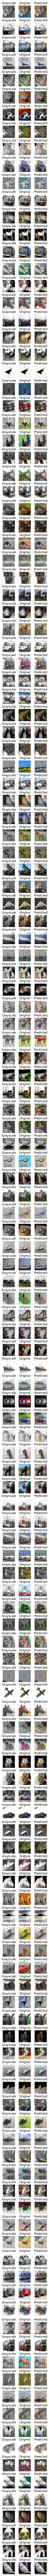

In [11]:
# Define the number of samples to generate
n_samples = 150
# Generate colorized versions of the first n_samples grayscale images in the test set
Y_hat = generator(X_test[:n_samples])

# Define the number of rows in the grid, which is equal to the number of samples
num_rows = len(Y_hat)

# Define the number of columns in the grid and the size of each image
num_cols = 3  # Number of columns in the grid
img_size = 1  # Size of each image in the grid

# Create a grid of subplots with num_rows rows and num_cols columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * img_size, num_rows * img_size))
fig.subplots_adjust(hspace=0.3, wspace=0.1)  # Adjust spacing between subplots

# Loop over the grayscale images, original color images, and colorized images
for row, (x, y, y_hat) in enumerate(zip(X_test[:n_samples], Y_test[:n_samples], Y_hat)):

    # Convert the original color image from Lab to RGB
    orig_lab = np.dstack((x, y * 128))
    orig_rgb = lab2rgb(orig_lab)

    # Convert the grayscale image from Lab to RGB
    grayscale_lab = np.dstack((x, np.zeros((IMAGE_SIZE, IMAGE_SIZE, 2))))
    grayscale_rgb = lab2rgb(grayscale_lab)

    # Convert the colorized image from Lab to RGB
    predicted_lab = np.dstack((x, y_hat * 128))
    predicted_rgb = lab2rgb(predicted_lab)
    
    # Display the grayscale image in the first column of the current row
    ax = axes[row, 0]  # Get the appropriate axis for the current subplot
    ax.axis('off')  # Turn off axis labels
    ax.imshow(grayscale_rgb)
    ax.set_title('Grayscale')

    # Display the original color image in the second column of the current row
    ax = axes[row, 1]  # Move to the next column for original RGB
    ax.axis('off')
    ax.imshow(orig_rgb)
    ax.set_title('Original')

    # Display the colorized image in the third column of the current row
    ax = axes[row, 2]  # Move to the next column for predicted colorized image
    ax.axis('off')
    ax.imshow(predicted_rgb)
    ax.set_title('Predicted')

    # Print the current row number to the console
    sys.stdout.flush()
    sys.stdout.write('\r{} / {}'.format(row + 1, num_rows))

# Hide empty subplots if any
for ax_row in axes:
    for ax in ax_row:
        if not ax.has_data():
            ax.axis('off')

# Adjust the padding between subplots
plt.tight_layout(pad=0.5)
# Save the figure as an image file
plt.savefig(os.path.join(WORKDIR, 'results', 'image_grid.png'))
# Display the figure
plt.show()

## Save the Generator and Discriminator Trained Models

In [12]:
# Save the checkpoints of the models and optimizers so that they can be loaded later
# Save the generator model in the SavedModel format
tf.saved_model.save(generator, os.path.join(WORKDIR, "generator-saved-model"))

# Save the discriminator model in the SavedModel format
tf.saved_model.save(discriminator, os.path.join(WORKDIR, "disciminator-saved-model"))

INFO:tensorflow:Assets written to: content/drive/My Drive/Colab Notebooks/Workspace/generator-saved-model/assets


INFO:tensorflow:Assets written to: content/drive/My Drive/Colab Notebooks/Workspace/generator-saved-model/assets


INFO:tensorflow:Assets written to: content/drive/My Drive/Colab Notebooks/Workspace/disciminator-saved-model/assets


INFO:tensorflow:Assets written to: content/drive/My Drive/Colab Notebooks/Workspace/disciminator-saved-model/assets
